In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import interp

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier as KNN

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc

from sklearn.dummy import DummyClassifier

# Load data

In [2]:
emotion_labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
target_labels = [val for key, val in emotion_labels.items()]
targets = [key for key, val in emotion_labels.items()]

In [3]:
def load_data(df, data_type):
    """Load data from DataFrame and return data to list 
    """
    image_data = []
    image_scaled = []
    
    for index, row in df.iterrows():
        if data_type == 1:
            field = row.pca
        elif data_type == 2:
            field = row.histogram
        elif data_type == 3:
            field = row.hog
        elif data_type == 4:
            field = row.lda
        else:
            field = row.pixels
        image = np.fromstring(field, sep=' ')
        image_data.append(image)
        if data_type == 0:
            scale = image / 255.0
            image_scaled.append(scale)
        
    return image_data, image_scaled

# Grid Search with PCA data

Find out the good tuning for hyper parameter with PCA data because it takes long time to get result with original data.

In [4]:
df = pd.read_csv('../data/pca/fer_pca.csv')
df.head()

,usage,emotion,pca
0,train,3,-0.45897132584662165 0.9620935463883798 -0.557...
1,train,3,0.49198604184990036 -1.0021801630235379 0.2740...
2,train,3,-0.941950107657087 1.4385249489843865 0.293738...
3,train,3,-1.2800578618783163 0.23932335345426428 0.4704...
4,train,3,0.10681625087573664 -0.7089926999517346 0.3826...


In [5]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 1)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 1)
test_target = list(df_test.emotion)

In [6]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(31432, 103)
(31432,)
(7896, 103)
(7896,)


## Find out which hyper parameters are best

In [8]:
param_grid = [{'n_neighbors': list(range(2,50)),
               'weights': ['uniform', 'distance'], 
               'metric': ['minkowski', 'euclidean', 'manhattan']}]

knn = KNN()

gs = GridSearchCV(estimator=knn, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
clf = gs.fit(X_train, y_train)

In [9]:
print(clf.best_score_)
print(clf.best_params_)
result = clf.best_estimator_
print('Test accuracy: %.3f' % result.score(X_test, y_test))

0.4439744729391782
{'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}
Test accuracy: 0.461


Following comparison use n_neighbors as 2, distance weights, and minkowski metric.

# KNN with original dataset

In [10]:
df = pd.read_csv('../data/fer_data.csv')
df.head()

,usage,emotion,pixels
0,train,3,108 83 63 65 89 111 121 121 125 111 103 105 11...
1,train,3,137 142 159 162 158 134 113 167 174 177 164 12...
2,train,3,111 148 155 167 181 191 194 193 195 199 203 20...
3,train,3,151 156 121 100 80 116 151 169 183 185 192 190...
4,train,3,248 187 149 130 97 140 139 117 197 251 231 255...


In [11]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 0)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 0)
test_target = list(df_test.emotion)

In [12]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(31432, 2304)
(31432,)
(7896, 2304)
(7896,)


In [14]:
knn = KNN(n_neighbors=2, weights='distance', metric='minkowski')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Train Accuracy: %.3f' % knn.score(X_train, y_train))
print('Test Accuracy: %.3f' % knn.score(X_test, y_test))

Train Accuracy: 0.998
Test Accuracy: 0.463


In [15]:
orig_predictions = [y_pred]
orig_actuals = [y_test]

In [16]:
# Scaled data
X_train = np.array(train_scaled)
y_train = np.array(train_target)
X_test = np.array(test_scaled)
y_test = np.array(test_target)

In [17]:
knn = KNN(n_neighbors=2, weights='distance', metric='minkowski')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Train Accuracy: %.3f' % knn.score(X_train, y_train))
print('Test Accuracy: %.3f' % knn.score(X_test, y_test))

Train Accuracy: 1.000
Test Accuracy: 0.463


In [18]:
orig_predictions.append(y_pred)
orig_actuals.append(y_test)

## Evaluation

### Confusion matrix

In [19]:
def show_confusion_matrix(confmat):
    """Display confusion matrix with percent values 
    """
    
    confmat = confmat/np.sum(confmat) * 100
    
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            percent = "{:.2f}".format(confmat[i, j])
            ax.text(x=j, y=i, s=percent+'%', va='center', ha='center')


    ax.set_xticklabels([''] + target_labels)
    ax.set_yticklabels([''] + target_labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_940/2811923800.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_940/2811923800.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


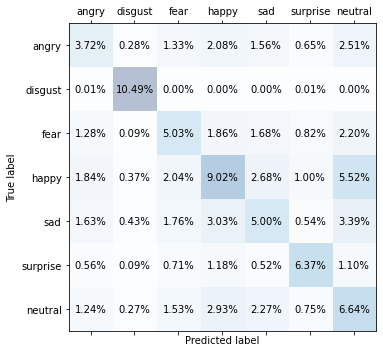

In [20]:
i = 0
confmat = confusion_matrix(y_true=orig_actuals[i], y_pred=orig_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Parformance matrics & Classification reports

In [21]:
i = 0
print('Precision: %.3f' % precision_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('Recall: %.3f' % recall_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('F1: %.3f' % f1_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('Accuracy: %.3f' % accuracy_score(y_true=orig_actuals[i], y_pred=orig_predictions[i]))
print(classification_report(y_true=orig_actuals[i], y_pred=orig_predictions[i], target_names=target_labels))

Precision: 0.485
Recall: 0.492
F1: 0.485
Accuracy: 0.463
              precision    recall  f1-score   support

       angry       0.36      0.31      0.33       957
     disgust       0.87      1.00      0.93       830
        fear       0.41      0.39      0.40      1024
       happy       0.45      0.40      0.42      1774
         sad       0.36      0.32      0.34      1247
    surprise       0.63      0.61      0.62       831
     neutral       0.31      0.42      0.36      1233

    accuracy                           0.46      7896
   macro avg       0.48      0.49      0.49      7896
weighted avg       0.46      0.46      0.46      7896



In [22]:
i = 1
print('Precision: %.3f' % precision_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('Recall: %.3f' % recall_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('F1: %.3f' % f1_score(y_true=orig_actuals[i], y_pred=orig_predictions[i], average='macro'))
print('Accuracy: %.3f' % accuracy_score(y_true=orig_actuals[i], y_pred=orig_predictions[i]))
print(classification_report(y_true=orig_actuals[i], y_pred=orig_predictions[i], target_names=target_labels))

Precision: 0.485
Recall: 0.492
F1: 0.485
Accuracy: 0.463
              precision    recall  f1-score   support

       angry       0.36      0.31      0.33       957
     disgust       0.87      1.00      0.93       830
        fear       0.41      0.39      0.40      1024
       happy       0.45      0.40      0.42      1774
         sad       0.36      0.32      0.34      1247
    surprise       0.63      0.61      0.62       831
     neutral       0.31      0.42      0.36      1233

    accuracy                           0.46      7896
   macro avg       0.48      0.49      0.49      7896
weighted avg       0.46      0.46      0.46      7896



# KNN with PCA

In [23]:
def processKNN(csv, data_type):
    """Process KNN for each csv data
    """
    print(csv)
    df = pd.read_csv(csv)
    df.head()
    
    df_train = df[df['usage']=='train']
    df_test = df[df['usage']=='test']
    train_data, train_scaled = load_data(df_train, data_type)
    train_target = list(df_train.emotion)
    test_data, test_scaled = load_data(df_test, data_type)
    test_target = list(df_test.emotion)
    
    X_train = np.array(train_data)
    y_train = np.array(train_target)
    X_test = np.array(test_data)
    y_test = np.array(test_target)
    
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    
    knn = KNN(n_neighbors=2, weights='distance', metric='minkowski')
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print('Train Accuracy: %.3f' % knn.score(X_train, y_train))
    print('Test Accuracy: %.3f' % knn.score(X_test, y_test))
    
    return y_pred, y_test

In [24]:
csv_list = ['../data/pca/fer_pca.csv', '../data/pca/fer_pca_inverse.csv', '../data/pca/fer_pca_norm.csv', 
            '../data/pca/fer_pca_std.csv', '../data/pca/fer_pca_scaled.csv']

In [25]:
pca_predictions = []
pca_actuals = []
for i in range(len(csv_list)):
    pred, act = processKNN(csv_list[i], 1)
    pca_predictions.append(pred)
    pca_actuals.append(act)

../data/pca/fer_pca.csv
(31432, 103)
(31432,)
(7896, 103)
(7896,)
Train Accuracy: 0.999
Test Accuracy: 0.461
../data/pca/fer_pca_inverse.csv
(31432, 2304)
(31432,)
(7896, 2304)
(7896,)
Train Accuracy: 0.998
Test Accuracy: 0.471
../data/pca/fer_pca_norm.csv
(31432, 157)
(31432,)
(7896, 157)
(7896,)
Train Accuracy: 0.999
Test Accuracy: 0.444
../data/pca/fer_pca_std.csv
(31432, 112)
(31432,)
(7896, 112)
(7896,)
Train Accuracy: 0.999
Test Accuracy: 0.470
../data/pca/fer_pca_scaled.csv
(31432, 103)
(31432,)
(7896, 103)
(7896,)
Train Accuracy: 0.999
Test Accuracy: 0.461


## Evaluation

### Confusion matrix

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_940/2811923800.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_940/2811923800.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


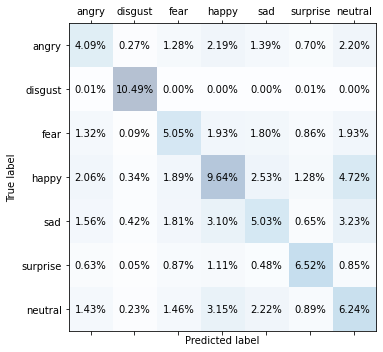

In [26]:
# Show only the best one 
i = 1
confmat = confusion_matrix(y_true=pca_actuals[i], y_pred=pca_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Performance matrics & Classification reports

In [27]:
def showPerformance(predictions, actuals):
    """Display performance of each result
    """
    for i in range(len(csv_list)):
        print(csv_list[i])
        print('Precision: %.3f' % precision_score(y_true=actuals[i], y_pred=predictions[i], average='macro'))
        print('Recall: %.3f' % recall_score(y_true=actuals[i], y_pred=predictions[i], average='macro'))
        print('F1: %.3f' % f1_score(y_true=actuals[i], y_pred=predictions[i], average='macro'))
        print('Accuracy: %.3f' % accuracy_score(y_true=actuals[i], y_pred=predictions[i]))
        print('Classification reports')
        print(classification_report(actuals[i], predictions[i], target_names=list(target_labels)))

In [28]:
showPerformance(pca_predictions, pca_actuals)

../data/pca/fer_pca.csv
Precision: 0.485
Recall: 0.487
F1: 0.481
Accuracy: 0.461
Classification reports
              precision    recall  f1-score   support

       angry       0.38      0.31      0.34       957
     disgust       0.87      1.00      0.93       830
        fear       0.36      0.37      0.37      1024
       happy       0.51      0.42      0.46      1774
         sad       0.36      0.29      0.32      1247
    surprise       0.62      0.57      0.59       831
     neutral       0.30      0.45      0.36      1233

    accuracy                           0.46      7896
   macro avg       0.48      0.49      0.48      7896
weighted avg       0.47      0.46      0.46      7896

../data/pca/fer_pca_inverse.csv
Precision: 0.488
Recall: 0.499
F1: 0.492
Accuracy: 0.471
Classification reports
              precision    recall  f1-score   support

       angry       0.37      0.34      0.35       957
     disgust       0.88      1.00      0.94       830
        fear       0.41 

# KNN with FisherFace

In [29]:
csv_list = ['../data/lda/fer_lda.csv', '../data/lda/fer_lda_norm.csv', '../data/lda/fer_lda_std.csv', '../data/lda/fer_lda_scaled.csv']

In [30]:
lda_predictions = []
lda_actuals = []
for i in range(len(csv_list)):
    pred, act = processKNN(csv_list[i], 4)
    lda_predictions.append(pred)
    lda_actuals.append(act)

../data/lda/fer_lda.csv
(31432, 6)
(31432,)
(7896, 6)
(7896,)
Train Accuracy: 0.998
Test Accuracy: 0.407
../data/lda/fer_lda_norm.csv
(31432, 6)
(31432,)
(7896, 6)
(7896,)
Train Accuracy: 0.998
Test Accuracy: 0.401
../data/lda/fer_lda_std.csv
(31432, 6)
(31432,)
(7896, 6)
(7896,)
Train Accuracy: 0.998
Test Accuracy: 0.415
../data/lda/fer_lda_scaled.csv
(31432, 6)
(31432,)
(7896, 6)
(7896,)
Train Accuracy: 0.998
Test Accuracy: 0.410


## Evaluation

### Confusion matrix

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_940/2811923800.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_940/2811923800.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


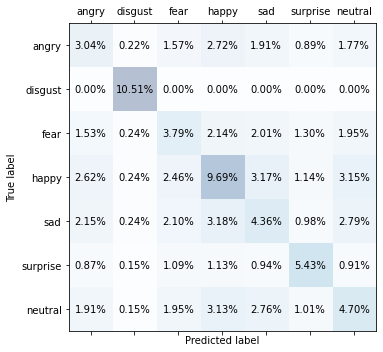

In [31]:
# Show only the best one 
i = 2
confmat = confusion_matrix(y_true=lda_actuals[i], y_pred=lda_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Parformance matrics & Classification reports

In [32]:
showPerformance(lda_predictions, lda_actuals)

../data/lda/fer_lda.csv
Precision: 0.417
Recall: 0.429
F1: 0.423
Accuracy: 0.407
Classification reports
              precision    recall  f1-score   support

       angry       0.23      0.24      0.24       957
     disgust       0.90      1.00      0.95       830
        fear       0.28      0.28      0.28      1024
       happy       0.46      0.44      0.45      1774
         sad       0.27      0.26      0.26      1247
    surprise       0.48      0.50      0.49       831
     neutral       0.29      0.29      0.29      1233

    accuracy                           0.41      7896
   macro avg       0.42      0.43      0.42      7896
weighted avg       0.40      0.41      0.40      7896

../data/lda/fer_lda_norm.csv
Precision: 0.411
Recall: 0.425
F1: 0.418
Accuracy: 0.401
Classification reports
              precision    recall  f1-score   support

       angry       0.24      0.25      0.24       957
     disgust       0.89      1.00      0.94       830
        fear       0.26    

# KNN with SIFT

In [33]:
csv_list = ['../data/sift/sift_bof_100.csv', '../data/sift/sift_bof_500.csv', '../data/sift/sift_bof_1000.csv', 
            '../data/sift/sift_pca_bof_100.csv', '../data/sift/sift_pca_bof_500.csv', '../data/sift/sift_pca_bof_1000.csv']

In [34]:
sift_predictions = []
sift_actuals = []
for i in range(len(csv_list)):
    pred, act = processKNN(csv_list[i], 2)
    sift_predictions.append(pred)
    sift_actuals.append(act)

../data/sift/sift_bof_100.csv
(31427, 99)
(31427,)
(7895, 99)
(7895,)
Train Accuracy: 0.998
Test Accuracy: 0.166
../data/sift/sift_bof_500.csv
(31427, 499)
(31427,)
(7895, 499)
(7895,)
Train Accuracy: 0.998
Test Accuracy: 0.172
../data/sift/sift_bof_1000.csv
(31427, 999)
(31427,)
(7895, 999)
(7895,)
Train Accuracy: 0.998
Test Accuracy: 0.190
../data/sift/sift_pca_bof_100.csv
(31425, 99)
(31425,)
(7894, 99)
(7894,)
Train Accuracy: 0.998
Test Accuracy: 0.158
../data/sift/sift_pca_bof_500.csv
(31425, 499)
(31425,)
(7894, 499)
(7894,)
Train Accuracy: 0.998
Test Accuracy: 0.165
../data/sift/sift_pca_bof_1000.csv
(31425, 999)
(31425,)
(7894, 999)
(7894,)
Train Accuracy: 0.998
Test Accuracy: 0.185


## Evaluation

### Confusion matrix

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_940/2811923800.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_940/2811923800.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


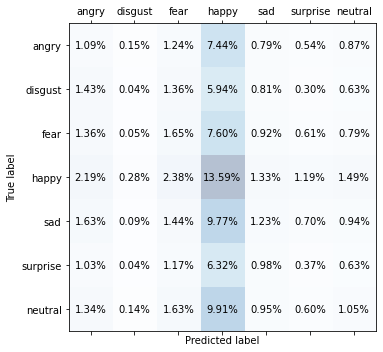

In [35]:
# Show only the best one 
i = 2
confmat = confusion_matrix(y_true=sift_actuals[i], y_pred=sift_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Parformance matrics & Classification reports

In [36]:
showPerformance(sift_predictions, sift_actuals)

../data/sift/sift_bof_100.csv
Precision: 0.137
Recall: 0.146
F1: 0.138
Accuracy: 0.166
Classification reports
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14       957
     disgust       0.04      0.00      0.01       830
        fear       0.13      0.16      0.14      1024
       happy       0.23      0.29      0.26      1773
         sad       0.16      0.19      0.18      1247
    surprise       0.10      0.07      0.08       831
     neutral       0.16      0.16      0.16      1233

    accuracy                           0.17      7895
   macro avg       0.14      0.15      0.14      7895
weighted avg       0.15      0.17      0.16      7895

../data/sift/sift_bof_500.csv
Precision: 0.161
Recall: 0.142
F1: 0.133
Accuracy: 0.172
Classification reports
              precision    recall  f1-score   support

       angry       0.12      0.11      0.11       957
     disgust       0.25      0.03      0.05       830
        fear       0

# KNN with KAZE

In [37]:
csv_list = ['../data/kaze/kaze_bof_100.csv', '../data/kaze/kaze_bof_500.csv', '../data/kaze/kaze_bof_1000.csv', 
            '../data/kaze/kaze_pca_bof_100.csv', '../data/kaze/kaze_pca_bof_500.csv', '../data/kaze/kaze_pca_bof_1000.csv']

In [38]:
kaze_predictions = []
kaze_actuals = []
for i in range(len(csv_list)):
    pred, act = processKNN(csv_list[i], 2)
    kaze_predictions.append(pred)
    kaze_actuals.append(act)

../data/kaze/kaze_bof_100.csv
(31284, 99)
(31284,)
(7856, 99)
(7856,)
Train Accuracy: 0.997
Test Accuracy: 0.165
../data/kaze/kaze_bof_500.csv
(31284, 499)
(31284,)
(7856, 499)
(7856,)
Train Accuracy: 0.997
Test Accuracy: 0.167
../data/kaze/kaze_bof_1000.csv
(31284, 999)
(31284,)
(7856, 999)
(7856,)
Train Accuracy: 0.998
Test Accuracy: 0.169
../data/kaze/kaze_pca_bof_100.csv
(31275, 99)
(31275,)
(7853, 99)
(7853,)
Train Accuracy: 0.995
Test Accuracy: 0.163
../data/kaze/kaze_pca_bof_500.csv
(31275, 499)
(31275,)
(7853, 499)
(7853,)
Train Accuracy: 0.997
Test Accuracy: 0.169
../data/kaze/kaze_pca_bof_1000.csv
(31275, 999)
(31275,)
(7853, 999)
(7853,)
Train Accuracy: 0.998
Test Accuracy: 0.171


## Evaluation

### Confusion matrix

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_940/2811923800.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_940/2811923800.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


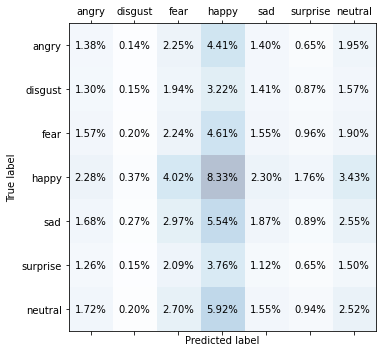

In [39]:
# Show only the best one 
i = 5
confmat = confusion_matrix(y_true=kaze_actuals[i], y_pred=kaze_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Parformance matrics & Classification reports

In [40]:
showPerformance(kaze_predictions, kaze_actuals)

../data/kaze/kaze_bof_100.csv
Precision: 0.148
Recall: 0.144
F1: 0.138
Accuracy: 0.165
Classification reports
              precision    recall  f1-score   support

       angry       0.13      0.14      0.14       955
     disgust       0.14      0.02      0.03       821
        fear       0.14      0.17      0.15      1022
       happy       0.22      0.31      0.26      1770
         sad       0.16      0.15      0.15      1237
    surprise       0.11      0.08      0.09       828
     neutral       0.15      0.15      0.15      1223

    accuracy                           0.16      7856
   macro avg       0.15      0.14      0.14      7856
weighted avg       0.16      0.16      0.15      7856

../data/kaze/kaze_bof_500.csv
Precision: 0.169
Recall: 0.142
F1: 0.135
Accuracy: 0.167
Classification reports
              precision    recall  f1-score   support

       angry       0.12      0.12      0.12       955
     disgust       0.31      0.02      0.04       821
        fear       0

# KNN with ORB

In [41]:
csv_list = ['../data/orb/orb_bof_100.csv', '../data/orb/orb_bof_500.csv', '../data/orb/orb_bof_1000.csv', 
            '../data/orb/orb_pca_bof_100.csv', '../data/orb/orb_pca_bof_500.csv', '../data/orb/orb_pca_bof_1000.csv']

In [42]:
orb_predictions = []
orb_actuals = []
for i in range(len(csv_list)):
    pred, act = processKNN(csv_list[i], 2)
    orb_predictions.append(pred)
    orb_actuals.append(act)

../data/orb/orb_bof_100.csv
(31430, 99)
(31430,)
(7896, 99)
(7896,)
Train Accuracy: 0.998
Test Accuracy: 0.154
../data/orb/orb_bof_500.csv
(31430, 499)
(31430,)
(7896, 499)
(7896,)
Train Accuracy: 0.998
Test Accuracy: 0.138
../data/orb/orb_bof_1000.csv
(31430, 999)
(31430,)
(7896, 999)
(7896,)
Train Accuracy: 0.998
Test Accuracy: 0.133
../data/orb/orb_pca_bof_100.csv
(31400, 99)
(31400,)
(7890, 99)
(7890,)
Train Accuracy: 0.998
Test Accuracy: 0.168
../data/orb/orb_pca_bof_500.csv
(31400, 499)
(31400,)
(7890, 499)
(7890,)
Train Accuracy: 0.998
Test Accuracy: 0.160
../data/orb/orb_pca_bof_1000.csv
(31400, 999)
(31400,)
(7890, 999)
(7890,)
Train Accuracy: 0.998
Test Accuracy: 0.169


## Evaluation

### Confusion matrix

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_940/2811923800.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_940/2811923800.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


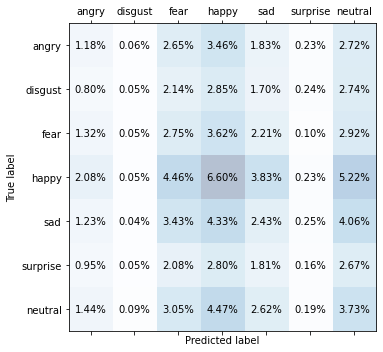

In [43]:
# Show only the best one 
i = 5
confmat = confusion_matrix(y_true=orb_actuals[i], y_pred=orb_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Parformance matrics & Classification reports

In [44]:
showPerformance(orb_predictions, orb_actuals)

../data/orb/orb_bof_100.csv
Precision: 0.133
Recall: 0.135
F1: 0.129
Accuracy: 0.154
Classification reports
              precision    recall  f1-score   support

       angry       0.11      0.10      0.10       957
     disgust       0.09      0.03      0.05       830
        fear       0.11      0.09      0.10      1024
       happy       0.22      0.25      0.23      1774
         sad       0.17      0.15      0.16      1247
    surprise       0.09      0.07      0.08       831
     neutral       0.15      0.25      0.19      1233

    accuracy                           0.15      7896
   macro avg       0.13      0.13      0.13      7896
weighted avg       0.14      0.15      0.15      7896

../data/orb/orb_bof_500.csv
Precision: 0.198
Recall: 0.148
F1: 0.103
Accuracy: 0.138
Classification reports
              precision    recall  f1-score   support

       angry       0.14      0.08      0.10       957
     disgust       0.46      0.01      0.01       830
        fear       0.13 

/Users/chikakoolsen/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chikakoolsen/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chikakoolsen/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chik

# KNN with BRISK

In [45]:
csv_list = ['../data/brisk/brisk_bof_100.csv', '../data/brisk/brisk_bof_500.csv', '../data/brisk/brisk_bof_1000.csv', 
            '../data/brisk/brisk_pca_bof_100.csv', '../data/brisk/brisk_pca_bof_500.csv', '../data/brisk/brisk_pca_bof_1000.csv']

In [46]:
brisk_predictions = []
brisk_actuals = []
for i in range(len(csv_list)):
    pred, act = processKNN(csv_list[i], 2)
    brisk_predictions.append(pred)
    brisk_actuals.append(act)

../data/brisk/brisk_bof_100.csv
(30833, 99)
(30833,)
(7731, 99)
(7731,)
Train Accuracy: 0.979
Test Accuracy: 0.170
../data/brisk/brisk_bof_500.csv
(30833, 499)
(30833,)
(7731, 499)
(7731,)
Train Accuracy: 0.990
Test Accuracy: 0.182
../data/brisk/brisk_bof_1000.csv
(30833, 999)
(30833,)
(7731, 999)
(7731,)
Train Accuracy: 0.994
Test Accuracy: 0.174
../data/brisk/brisk_pca_bof_100.csv
(8004, 99)
(8004,)
(2160, 99)
(2160,)
Train Accuracy: 0.696
Test Accuracy: 0.199
../data/brisk/brisk_pca_bof_500.csv
(8004, 499)
(8004,)
(2160, 499)
(2160,)
Train Accuracy: 0.778
Test Accuracy: 0.163
../data/brisk/brisk_pca_bof_1000.csv
(8004, 999)
(8004,)
(2160, 999)
(2160,)
Train Accuracy: 0.817
Test Accuracy: 0.170


## Evaluation

### Confusion matrix

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_940/2811923800.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_940/2811923800.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


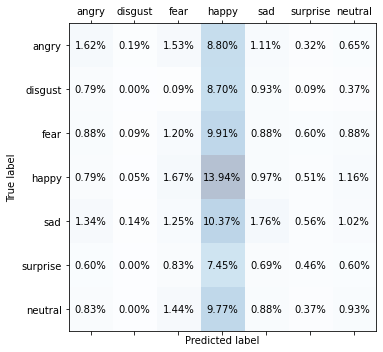

In [47]:
# Show only the best one 
i = 3
confmat = confusion_matrix(y_true=brisk_actuals[i], y_pred=brisk_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Parformance matrics & Classification reports

In [48]:
showPerformance(brisk_predictions, brisk_actuals)

../data/brisk/brisk_bof_100.csv
Precision: 0.137
Recall: 0.141
F1: 0.129
Accuracy: 0.170
Classification reports
              precision    recall  f1-score   support

       angry       0.13      0.12      0.12       942
     disgust       0.05      0.01      0.01       814
        fear       0.14      0.16      0.15      1001
       happy       0.21      0.40      0.28      1741
         sad       0.15      0.17      0.16      1200
    surprise       0.13      0.05      0.07       823
     neutral       0.14      0.08      0.10      1210

    accuracy                           0.17      7731
   macro avg       0.14      0.14      0.13      7731
weighted avg       0.15      0.17      0.15      7731

../data/brisk/brisk_bof_500.csv
Precision: 0.146
Recall: 0.144
F1: 0.126
Accuracy: 0.182
Classification reports
              precision    recall  f1-score   support

       angry       0.14      0.10      0.11       942
     disgust       0.12      0.02      0.03       814
        fear    

# KNN with AKAZE

In [49]:
csv_list = ['../data/akaze/akaze_bof_100.csv', '../data/akaze/akaze_bof_500.csv', '../data/akaze/akaze_bof_1000.csv', 
            '../data/akaze/akaze_pca_bof_100.csv', '../data/akaze/akaze_pca_bof_500.csv', '../data/akaze/akaze_pca_bof_1000.csv']

In [50]:
akaze_predictions = []
akaze_actuals = []
for i in range(len(csv_list)):
    pred, act = processKNN(csv_list[i], 2)
    akaze_predictions.append(pred)
    akaze_actuals.append(act)

../data/akaze/akaze_bof_100.csv
(31332, 99)
(31332,)
(7862, 99)
(7862,)
Train Accuracy: 0.997
Test Accuracy: 0.158
../data/akaze/akaze_bof_500.csv
(31332, 499)
(31332,)
(7862, 499)
(7862,)
Train Accuracy: 0.998
Test Accuracy: 0.168
../data/akaze/akaze_bof_1000.csv
(31332, 999)
(31332,)
(7862, 999)
(7862,)
Train Accuracy: 0.998
Test Accuracy: 0.180
../data/akaze/akaze_pca_bof_100.csv
(25314, 99)
(25314,)
(6606, 99)
(6606,)
Train Accuracy: 0.814
Test Accuracy: 0.193
../data/akaze/akaze_pca_bof_500.csv
(25314, 499)
(25314,)
(6606, 499)
(6606,)
Train Accuracy: 0.870
Test Accuracy: 0.202
../data/akaze/akaze_pca_bof_1000.csv
(25314, 999)
(25314,)
(6606, 999)
(6606,)
Train Accuracy: 0.885
Test Accuracy: 0.196


## Evaluation

### Confusion matrix

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_940/2811923800.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_940/2811923800.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


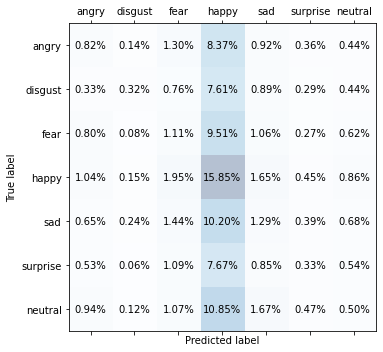

In [51]:
# Show only the best one 
i = 4
confmat = confusion_matrix(y_true=akaze_actuals[i], y_pred=akaze_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Parformance matrics & Classification reports

In [52]:
showPerformance(akaze_predictions, akaze_actuals)

../data/akaze/akaze_bof_100.csv
Precision: 0.136
Recall: 0.138
F1: 0.132
Accuracy: 0.158
Classification reports
              precision    recall  f1-score   support

       angry       0.12      0.14      0.13       954
     disgust       0.08      0.01      0.02       822
        fear       0.11      0.13      0.12      1022
       happy       0.21      0.27      0.24      1766
         sad       0.15      0.19      0.17      1237
    surprise       0.11      0.06      0.07       831
     neutral       0.17      0.16      0.16      1230

    accuracy                           0.16      7862
   macro avg       0.14      0.14      0.13      7862
weighted avg       0.15      0.16      0.15      7862

../data/akaze/akaze_bof_500.csv
Precision: 0.140
Recall: 0.140
F1: 0.129
Accuracy: 0.168
Classification reports
              precision    recall  f1-score   support

       angry       0.13      0.14      0.13       954
     disgust       0.06      0.01      0.01       822
        fear    

# KNN with HoG

In [53]:
csv_list = ['../data/hog/hog_data2.csv', '../data/hog/hog_scaled2.csv']

In [54]:
hog_predictions = []
hog_actuals = []
for i in range(len(csv_list)):
    pred, act = processKNN(csv_list[i], 3)
    hog_predictions.append(pred)
    hog_actuals.append(act)

../data/hog/hog_data2.csv
(31432, 2304)
(31432,)
(7896, 2304)
(7896,)
Train Accuracy: 0.998
Test Accuracy: 0.521
../data/hog/hog_scaled2.csv
(31432, 2304)
(31432,)
(7896, 2304)
(7896,)
Train Accuracy: 0.998
Test Accuracy: 0.517


## Evaluation

### Confusion matrix

/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_940/2811923800.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + target_labels)
/var/folders/yd/vkjb_lqj2_30lnyhzhjqtg9w0000gp/T/ipykernel_940/2811923800.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + target_labels)


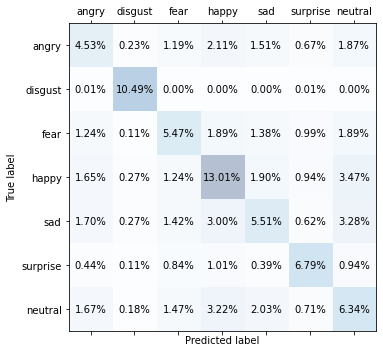

In [55]:
# Show only the best one 
i = 0
confmat = confusion_matrix(y_true=hog_actuals[i], y_pred=hog_predictions[i], labels=targets)
show_confusion_matrix(confmat)

### Parformance matrics & Classification reports

In [56]:
showPerformance(hog_predictions, hog_actuals)

../data/hog/hog_data2.csv
Precision: 0.533
Recall: 0.539
F1: 0.534
Accuracy: 0.521
Classification reports
              precision    recall  f1-score   support

       angry       0.40      0.37      0.39       957
     disgust       0.90      1.00      0.95       830
        fear       0.47      0.42      0.44      1024
       happy       0.54      0.58      0.56      1774
         sad       0.43      0.35      0.39      1247
    surprise       0.63      0.65      0.64       831
     neutral       0.36      0.41      0.38      1233

    accuracy                           0.52      7896
   macro avg       0.53      0.54      0.53      7896
weighted avg       0.52      0.52      0.52      7896

../data/hog/hog_scaled2.csv
Precision: 0.526
Recall: 0.535
F1: 0.529
Accuracy: 0.517
Classification reports
              precision    recall  f1-score   support

       angry       0.40      0.38      0.39       957
     disgust       0.90      1.00      0.95       830
        fear       0.46   

# Benchmark

## Find out best parameter for benchmark

In [4]:
# Use original dataset 
df = pd.read_csv('../data/fer_data.csv')
df.head()

,usage,emotion,pixels
0,train,3,108 83 63 65 89 111 121 121 125 111 103 105 11...
1,train,3,137 142 159 162 158 134 113 167 174 177 164 12...
2,train,3,111 148 155 167 181 191 194 193 195 199 203 20...
3,train,3,151 156 121 100 80 116 151 169 183 185 192 190...
4,train,3,248 187 149 130 97 140 139 117 197 251 231 255...


In [5]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 0)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 0)
test_target = list(df_test.emotion)

In [6]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [7]:
# Check which strategy make is best
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.2295113260371596

In [8]:
dummy.score(X_test, y_test)

0.2246707193515704

In [63]:
dummy = DummyClassifier(strategy='prior')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.2295113260371596

In [64]:
dummy.score(X_test, y_test)

0.2246707193515704

In [65]:
dummy = DummyClassifier(strategy='stratified')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.1583418172562993

In [66]:
dummy.score(X_test, y_test)

0.1495694022289767

In [67]:
dummy = DummyClassifier(strategy='uniform', random_state=1)
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.14167090862814966

In [68]:
dummy.score(X_test, y_test)

0.1469098277608916

In [69]:
dummy = DummyClassifier(strategy='constant', constant=1)
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.10085263425808094

In [70]:
dummy.score(X_test, y_test)

0.10511651469098278

Most_frequent or prior are best for strategy parameter.

## Check with Best PCA data

In [71]:
df = pd.read_csv('../data/pca/fer_pca_inverse.csv')
df.head()

,usage,emotion,pca
0,train,3,104 109 102 94 93 99 106 110 109 106 103 106 1...
1,train,3,146 148 148 148 151 153 155 154 152 150 151 15...
2,train,3,111 122 135 152 172 185 193 196 196 198 198 20...
3,train,3,143 142 133 123 118 125 141 162 183 198 205 20...
4,train,3,220 201 167 130 99 94 110 138 165 181 193 191 ...


In [72]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 1)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 1)
test_target = list(df_test.emotion)

In [73]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [74]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.2295113260371596

In [75]:
dummy.score(X_test, y_test)

0.2246707193515704

## Check with Best LDA data

In [76]:
df = pd.read_csv('../data/lda/fer_lda_std.csv')
df.head()

,usage,emotion,lda
0,train,3,0.7894818314647534 0.2147150019296881 -0.87952...
1,train,3,0.6069599043975686 -0.20427589187483838 0.2641...
2,train,3,-0.2795828858633714 1.0125084423693098 -0.1462...
3,train,3,-0.12393359351771732 0.4088989785758754 -1.315...
4,train,3,-0.14131908024016165 1.0288778060846748 -0.484...


In [77]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 4)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 4)
test_target = list(df_test.emotion)

In [78]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [79]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.2295113260371596

In [80]:
dummy.score(X_test, y_test)

0.2246707193515704

## Check with best BoF

In [81]:
df = pd.read_csv('../data/sift/sift_bof_100.csv')
df.head()

,usage,emotion,histogram
0,train,3,0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,train,3,0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 ...
2,train,3,1 2 0 0 0 0 0 0 1 1 2 0 0 0 0 0 0 0 1 0 0 1 0 ...
3,train,3,0 0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 1 0 0 0 0 1 0 ...
4,train,3,0 1 2 0 1 0 1 0 0 0 0 1 0 1 1 0 0 3 0 0 0 1 0 ...


In [82]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 2)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 2)
test_target = list(df_test.emotion)

In [83]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [84]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.22954784102841505

In [85]:
dummy.score(X_test, y_test)

0.224572514249525

## Check with best HoG

In [11]:
df = pd.read_csv('../data/hog/hog_data2.csv')
df.head()

,usage,emotion,hog
0,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [12]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 3)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 3)
test_target = list(df_test.emotion)

In [13]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [14]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.2295113260371596

In [15]:
dummy.score(X_test, y_test)

0.2246707193515704

### Performance and Classification report

In [16]:
y_pred = dummy.predict(X_test)

In [17]:
print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred, average='macro'))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred, average='macro'))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred, average='macro'))
print('Accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))
print(classification_report(y_true=y_test, y_pred=y_pred, target_names=target_labels))

Precision: 0.032
Recall: 0.143
F1: 0.052
Accuracy: 0.225
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       957
     disgust       0.00      0.00      0.00       830
        fear       0.00      0.00      0.00      1024
       happy       0.22      1.00      0.37      1774
         sad       0.00      0.00      0.00      1247
    surprise       0.00      0.00      0.00       831
     neutral       0.00      0.00      0.00      1233

    accuracy                           0.22      7896
   macro avg       0.03      0.14      0.05      7896
weighted avg       0.05      0.22      0.08      7896



/Users/chikakoolsen/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chikakoolsen/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chikakoolsen/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chik

# Get better result

## Hyper parameter tuning

Use HoG data

In [19]:
df = pd.read_csv('../data/hog/hog_scaled2.csv')
df.head()

,usage,emotion,hog
0,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
4,train,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [20]:
df_train = df[df['usage']=='train']
df_test = df[df['usage']=='test']
train_data, train_scaled = load_data(df_train, 3)
train_target = list(df_train.emotion)
test_data, test_scaled = load_data(df_test, 3)
test_target = list(df_test.emotion)

In [21]:
X_train = np.array(train_data)
y_train = np.array(train_target)
X_test = np.array(test_data)
y_test = np.array(test_target)

In [16]:
param_grid = [{'weights': ['uniform', 'distance'], 
               'metric': ['minkowski', 'euclidean', 'manhattan']}]

knn = KNN(n_neighbors=2)

gs = GridSearchCV(estimator=knn, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
clf = gs.fit(X_train, y_train)

In [17]:
print(clf.best_score_)
print(clf.best_params_)
result = clf.best_estimator_
print('Train accuracy: %.3f' % result.score(X_train, y_train))
print('Test accuracy: %.3f' % result.score(X_test, y_test))

0.4958642190448665
{'metric': 'minkowski', 'weights': 'distance'}
Train accuracy: 0.998
Test accuracy: 0.517


Minkowski metric and distance weights are still the best.

## K-fold cross-validation

In [22]:
k_list = list(range(1,50))
cv_scores = []
for k in k_list:
    knn = KNN(n_neighbors=k, weights='distance', metric='minkowski')
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    # Append avg score to the list
    cv_scores.append(scores.mean())
    print('CV accuracy scores: %s' % scores)
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.4821883  0.50604326 0.48934139 0.50079542 0.48584155 0.51193128
 0.5058861  0.48647789 0.49825008 0.50652243]
CV accuracy: 0.497 +/- 0.010
CV accuracy scores: [0.48250636 0.50508906 0.48997773 0.50047725 0.48297805 0.5097041
 0.50397709 0.48711422 0.49538657 0.50143175]
CV accuracy: 0.496 +/- 0.009
CV accuracy scores: [0.48346056 0.50636132 0.48711422 0.49761374 0.49061406 0.50811327
 0.49793191 0.48806872 0.49856825 0.49984092]
CV accuracy: 0.496 +/- 0.008
CV accuracy scores: [0.48664122 0.50381679 0.47916004 0.50015908 0.48552339 0.50620426
 0.49347757 0.48297805 0.49188673 0.50047725]
CV accuracy: 0.493 +/- 0.009
CV accuracy scores: [0.47582697 0.50763359 0.47979637 0.49665924 0.47788737 0.49729558
 0.4912504  0.47502386 0.49379574 0.49825008]
CV accuracy: 0.489 +/- 0.011
CV accuracy scores: [0.4764631  0.50540712 0.47629653 0.49093223 0.48170538 0.49156857
 0.49284123 0.47820554 0.48806872 0.50015908]
CV accuracy: 0.488 +/- 0.009
CV accuracy scores: [0.472328

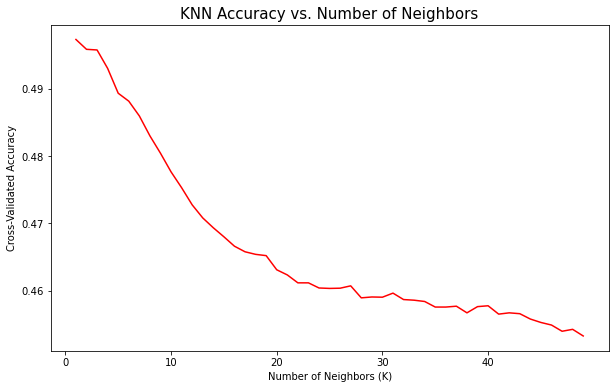

In [24]:
# Plot the cross-validated accuracy against n_neighbors parameter
plt.figure(figsize=(10,6))
plt.plot(k_list, cv_scores, color = 'red')
plt.title('KNN Accuracy vs. Number of Neighbors', size=15)
plt.xticks( range(0,50,10) )
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

# Visualizing learning curves

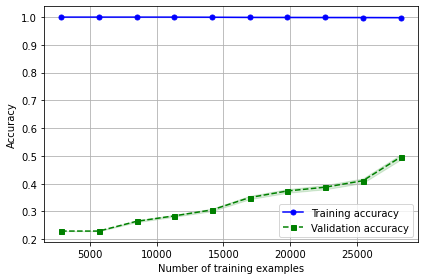

In [25]:
knn = KNN(n_neighbors=2, weights='distance', metric='minkowski')

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=knn,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()